In [105]:
import warnings
warnings.filterwarnings("ignore")
from keras.layers import Input, Dense,Conv1D, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Reshape, Embedding, LSTM, GlobalMaxPooling1D, BatchNormalization
from keras.models import Model
from keras.models import Sequential
from keras import backend as K
from keras import utils, optimizers
from keras.utils.np_utils import to_categorical
import numpy as np
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import SGD, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


### 1. Autoecoder

A convolutional autoencoder is a particular flavor of autoencoder where we
use convolutional layers instead of Dense layers. We have previously applied
autoencoders to images using only Dense layers and the result worked fairly
well. However, the local spatial correlations of images imply that we should
Be able to do better using convolutional layers instead of Dense layers.
Build and fit a convolutional autoencoder for the CIFAR10 dataset.
The components of this network will be many of the same pieces we’ve used
with convolutional classification networks: Conv2D, MaxPooling, and so on.
The encoder part of the network should run the input image through a few
convolutional layers of your choice. The decoder part of the network will utilize UpSampling2D to get the representation back to the original image size.
An example to guide your thinking can be found toward the bottom of this
Post https://blog.keras.io/building-autoencoders-in-keras.html.
DO NOT JUST COPY THIS CODE AND TURN IT IN. BE CREATIVE,
COME UP WITH YOUR OWN VARIATION.
After training your network, visualize some examples of input images and
their decoded reconstruction.

In [106]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train.shape
y_train.shape
x_test.shape
#y_test.shape

(10000, 32, 32, 3)

In [107]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


In [108]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same', use_bias=False)(input_img)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same', use_bias=False)(encoded)
x = BatchNormalization(axis=-1)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
x = UpSampling2D((4, 4))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', use_bias=False)(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='Adam', loss='categorical_crossentropy')


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        864       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)         

In [109]:
history = autoencoder.fit(x_train, x_train,
                                      epochs=100,
                                      batch_size=64,
                                      validation_data=(x_test, x_test))

Epoch 1/100
782/782 [==============================] - 241s 308ms/step - loss: 1.5455 - val_loss: 1.5527
Epoch 2/100
782/782 [==============================] - 241s 308ms/step - loss: 1.5417 - val_loss: 1.5522
Epoch 3/100
782/782 [==============================] - 240s 307ms/step - loss: 1.5411 - val_loss: 1.5515
Epoch 4/100
782/782 [==============================] - 242s 310ms/step - loss: 1.5407 - val_loss: 1.5511
Epoch 5/100
782/782 [==============================] - 240s 307ms/step - loss: 1.5404 - val_loss: 1.5512
Epoch 6/100
782/782 [==============================] - 240s 307ms/step - loss: 1.5403 - val_loss: 1.5507
Epoch 7/100
782/782 [==============================] - 241s 308ms/step - loss: 1.5401 - val_loss: 1.5528
Epoch 8/100
782/782 [==============================] - 241s 308ms/step - loss: 1.5400 - val_loss: 1.5509
Epoch 9/100
782/782 [==============================] - 241s 308ms/step - loss: 1.5398 - val_loss: 1.5505
Epoch 10/100
782/782 [==============================] -

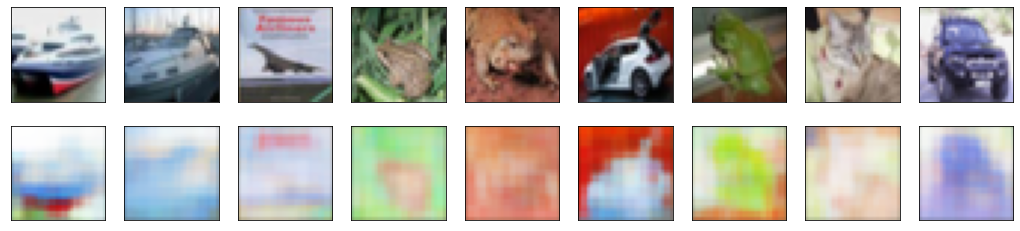

In [110]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 2. Image Classification

We’ll continue to use the CIFAR10 dataset and build a deep convolutional
network for classification

2.1 Deep CNN

Build a deep CNN to classify the images. Provide a brief description of the
architectural choices you’ve made: kernel sizes, strides, padding, network
depth.Train your network end-to-end. Report on your model’s performance
on the training set and test set.

In [ ]:
from keras.utils import np_utils
# load the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


# Data normalization

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [ ]:
# build the neural network
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(32,32,3))) 
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 32, 32, 64)        832       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 16, 16, 32)        8224      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)             

In [ ]:

callbacks = [early_stopping]

deep_cnn_history = model.fit(x_train,
                             y_train,
                             batch_size=64,
                             epochs=100,
                             validation_data=(x_test, y_test))
                             

Epoch 1/50
782/782 [==============================] - 85s 109ms/step - loss: 1.6743 - accuracy: 0.3912 - val_loss: 1.3602 - val_accuracy: 0.5256
Epoch 2/50
782/782 [==============================] - 85s 109ms/step - loss: 1.3600 - accuracy: 0.5124 - val_loss: 1.1927 - val_accuracy: 0.5786
Epoch 3/50
782/782 [==============================] - 86s 110ms/step - loss: 1.2377 - accuracy: 0.5567 - val_loss: 1.1168 - val_accuracy: 0.5999
Epoch 4/50
782/782 [==============================] - 85s 108ms/step - loss: 1.1711 - accuracy: 0.5833 - val_loss: 1.0334 - val_accuracy: 0.6371
Epoch 5/50
782/782 [==============================] - 84s 107ms/step - loss: 1.1127 - accuracy: 0.6044 - val_loss: 1.0104 - val_accuracy: 0.6446
Epoch 6/50
782/782 [==============================] - 84s 107ms/step - loss: 1.0781 - accuracy: 0.6180 - val_loss: 0.9623 - val_accuracy: 0.6621
Epoch 7/50
782/782 [==============================] - 86s 110ms/step - loss: 1.0392 - accuracy: 0.6335 - val_loss: 0.9374 - val_ac

313/313 [==============================] - 4s 14ms/step - loss: 0.7577 - accuracy: 0.7376
The test score is: [0.7577491998672485, 0.7376000285148621]


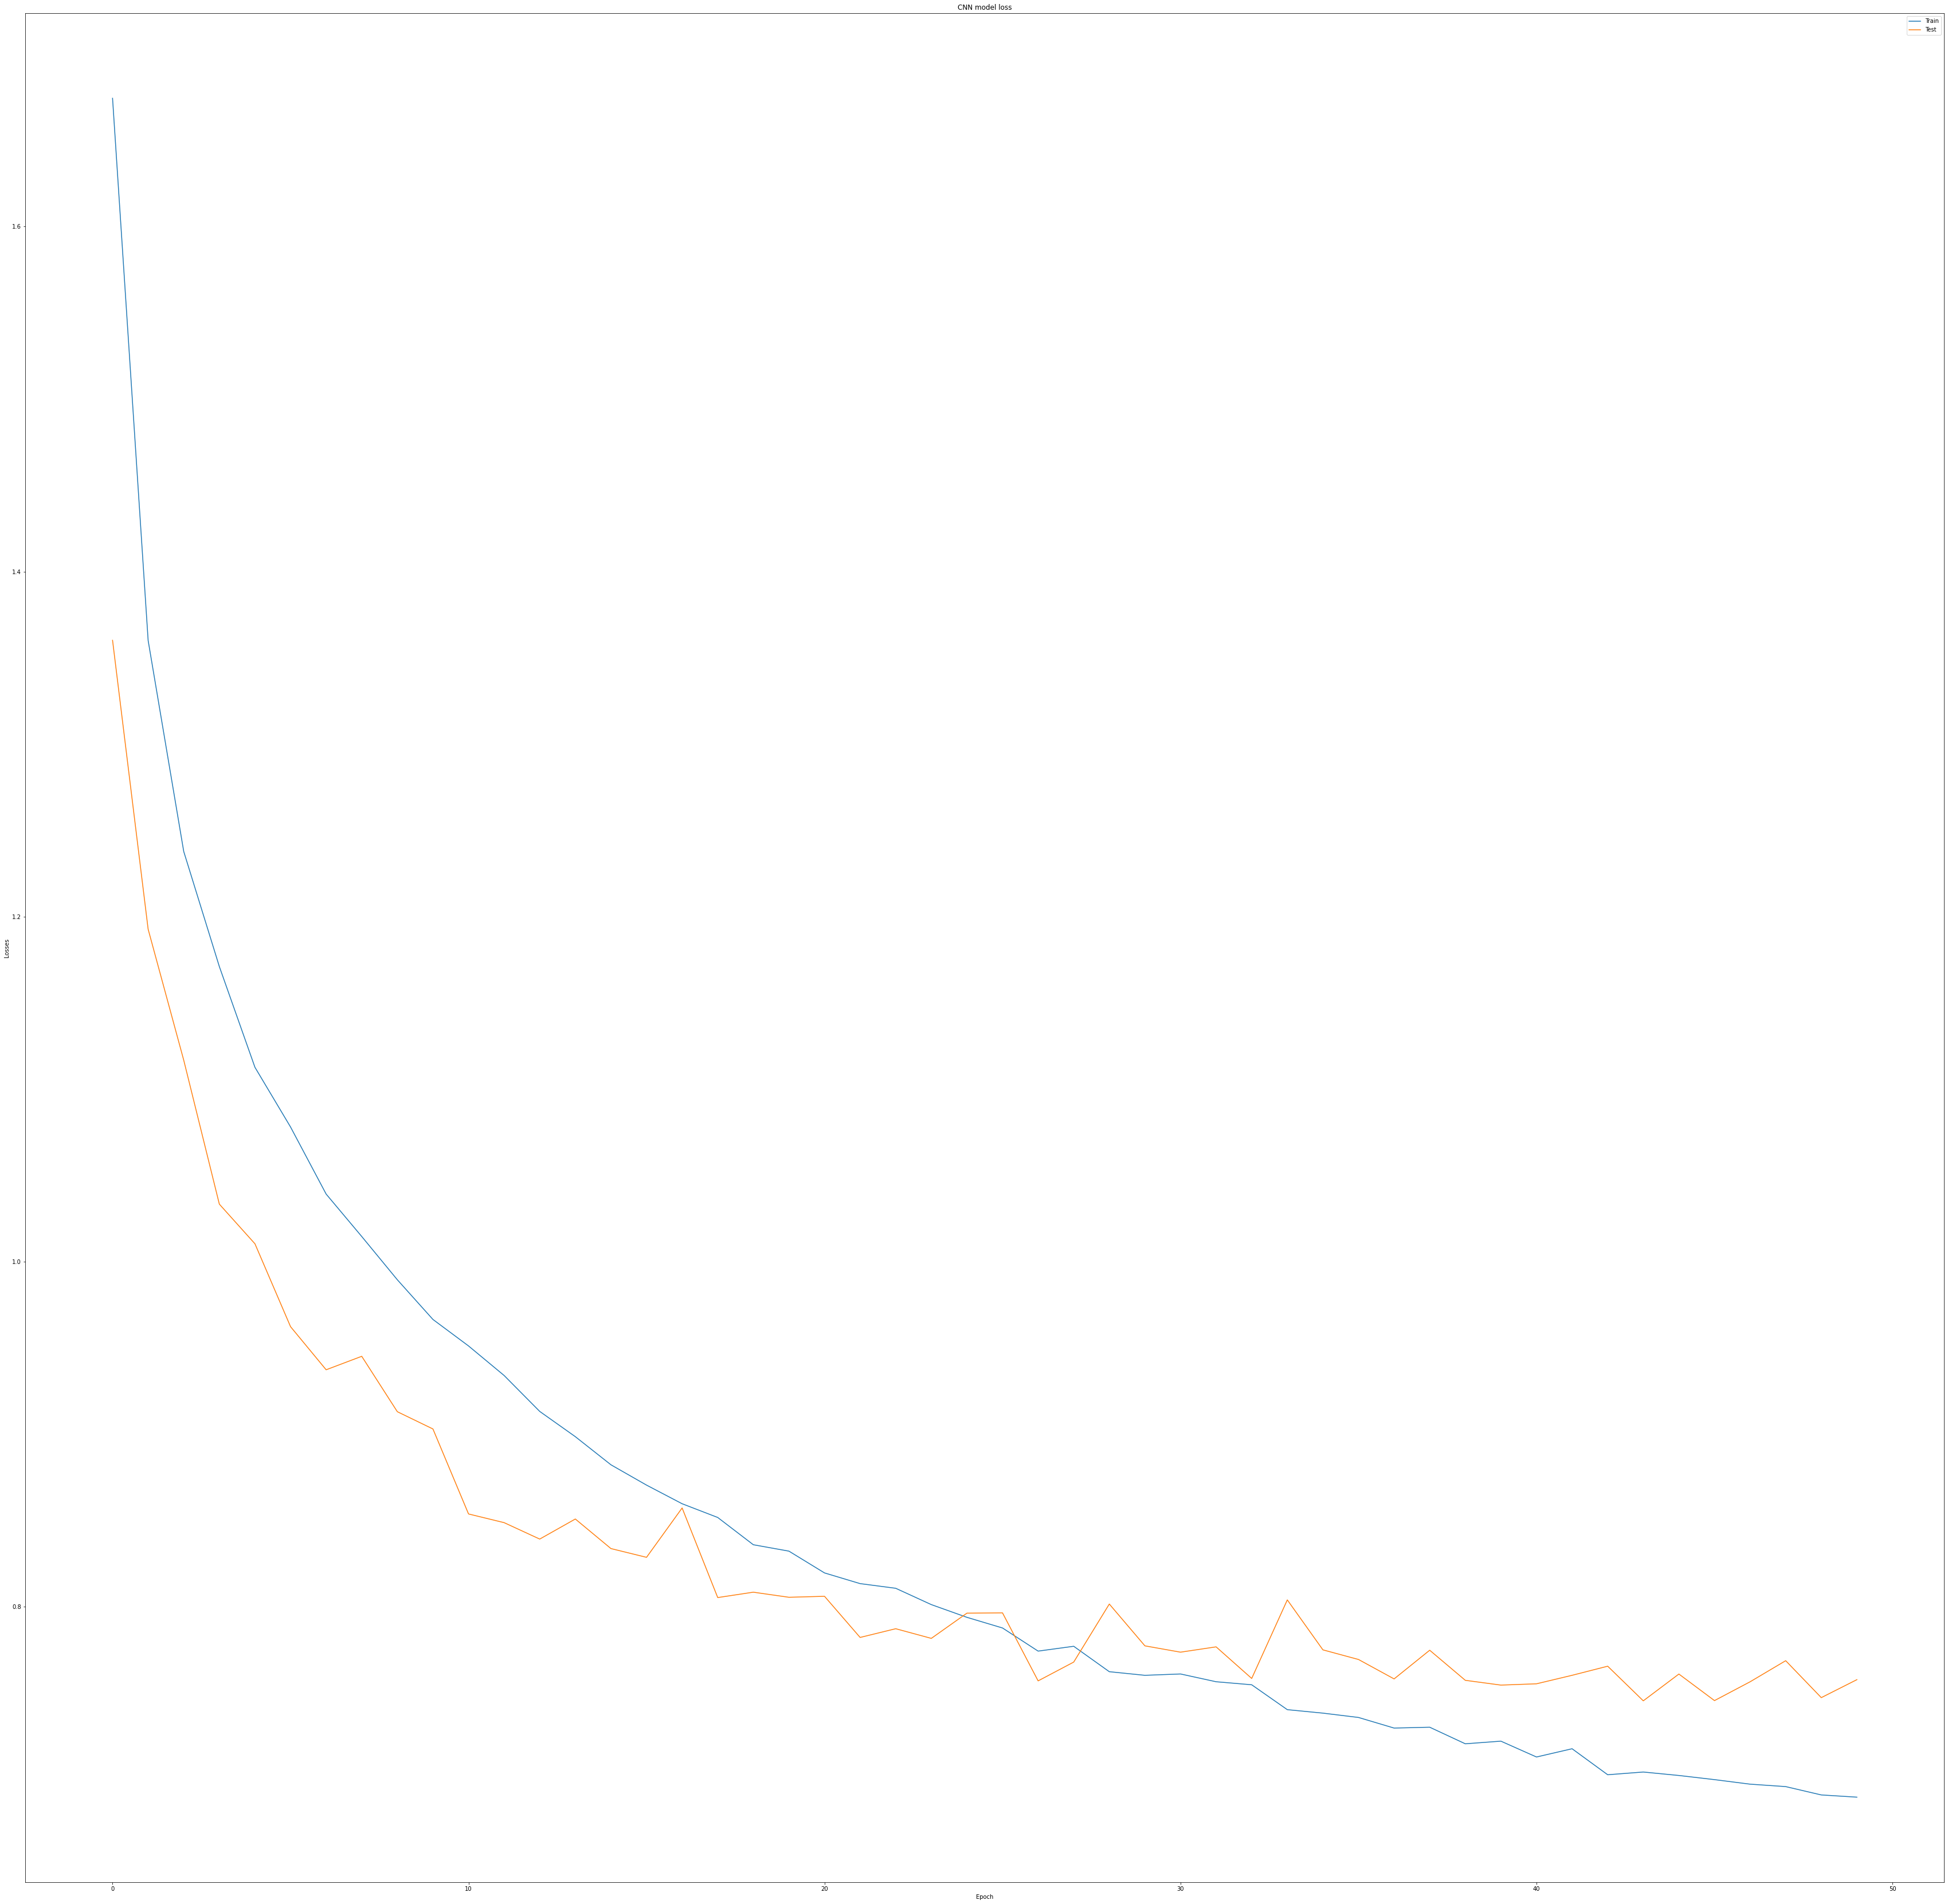

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)

print("The test score is: {acc}".format(acc = score))


def plot_loss(history):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('CNN model loss')
    plt.ylabel('Losses')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

plot_loss(deep_cnn_history)

2.2 Transfer Learning

Repeat the same task, but this time utilize a pre-trained network for the majority of your model. You should only train the final Dense layer, all other weights
should be fixed. You can use whichever pre-trained backbone you like (ResNet,
VGG, etc). Report on your model’s performance on the training set and test
set

In [2]:
from keras.applications import VGG16

In [6]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [17]:
from keras.utils import np_utils
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)
y_train.shape

(50000, 10)

In [18]:

conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (48,48,3))
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [19]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation='softmax'))


print('Before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('After freezing the conv base:', len(model.trainable_weights))


Before freezing the conv base: 30
After freezing the conv base: 4


In [20]:
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

x_train = preprocess_input(x_train)
x_test  = preprocess_input (x_test)

vgg = VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [21]:

train_images = np.array(list(map(lambda x: np.resize(x, (48,48,3)), x_train)))
train_images.shape

(50000, 48, 48, 3)

In [22]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, y_train, epochs=5, batch_size=64)

Epoch 1/5
782/782 [==============================] - 1144s 1s/step - loss: 2.5534 - accuracy: 0.0978
Epoch 2/5
782/782 [==============================] - 1144s 1s/step - loss: 2.3028 - accuracy: 0.0958
Epoch 3/5
782/782 [==============================] - 1144s 1s/step - loss: 2.3027 - accuracy: 0.0972
Epoch 4/5
782/782 [==============================] - 1141s 1s/step - loss: 2.3027 - accuracy: 0.0993
Epoch 5/5
782/782 [==============================] - 1145s 1s/step - loss: 2.3027 - accuracy: 0.0980


In [26]:
test_images = np.array(list(map(lambda x: np.resize(x, (48,48,3)), x_test)))
score_test = model.evaluate(test_images, y_test, verbose=0)
print(score_test[1])

0.10000000149011612


###3. Text Classification

While images contain local spatial correlations and structure, many other
datasets contain temporal correlations. Examples include time series and discrete sequences such as text. In this problem, we will tackle the task of text
classification in the context of natural language.
Background. In this problem, we will build models that read text segments
(messages) and identify whether they are SPAM or HAM.
Wikipedia describes SPAM as “the use of electronic messaging systems to
send unsolicited bulk messages, especially advertising, indiscriminately.”
The term ‘HAM’ was originally coined by SpamBayes sometime around 2001
and is currently defined and understood to be “E-mail that is generally desired
and isn’t considered SPAM.”
Dataset. The dataset consists of ∼ 5500 messages along with binary labels(SPAM or HAM) and is already preprocessed. So basically each sample is
like [MESSAGE, LABEL].

3.1 RNN
Build and train a Recurrent Neural Network to solve this text classification
task. You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).

In [27]:
import os
import numpy as np
import pandas as pd

In [28]:
import nltk

In [60]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM

In [30]:
import matplotlib.pyplot as plt
from IPython.display import SVG, display

In [31]:
from sklearn.metrics import roc_curve, auc

In [32]:
from google.colab import files
data_to_load = files.upload()

Saving SPAM_detection.csv to SPAM_detection.csv


In [48]:
import io
df = pd.read_csv(io.BytesIO(data_to_load['SPAM_detection.csv']))

In [49]:
df.head()

,Message,category_val
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [50]:
import string

In [52]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

In [54]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
word_index = tokenizer.word_index
print("unique number of tokens")
print(len(word_index))

unique number of tokens
9006


In [57]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Number of text tensor')
print(X.shape)

Number of text tensor
(5572, 250)


In [58]:
y = pd.get_dummies(df['category_val']).values
print( y.shape)

(5572, 2)


In [70]:
model_lstm = Sequential()
model_lstm.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(2, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 202       
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 919)
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)
print(X_test.shape)

(3900, 250)
(3900, 2)
(1672, 2)
(1672, 250)


In [72]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=64,validation_split=0.3)
          

Epoch 1/50
43/43 [==============================] - 33s 759ms/step - loss: 4.8562e-05 - accuracy: 1.0000 - val_loss: 0.0779 - val_accuracy: 0.9889
Epoch 2/50
43/43 [==============================] - 32s 754ms/step - loss: 3.1324e-05 - accuracy: 1.0000 - val_loss: 0.0785 - val_accuracy: 0.9889
Epoch 3/50
43/43 [==============================] - 33s 760ms/step - loss: 2.1995e-05 - accuracy: 1.0000 - val_loss: 0.0787 - val_accuracy: 0.9889
Epoch 4/50
43/43 [==============================] - 34s 784ms/step - loss: 1.9820e-05 - accuracy: 1.0000 - val_loss: 0.0793 - val_accuracy: 0.9889
Epoch 5/50
43/43 [==============================] - 33s 757ms/step - loss: 2.0726e-05 - accuracy: 1.0000 - val_loss: 0.0797 - val_accuracy: 0.9889
Epoch 6/50
43/43 [==============================] - 33s 761ms/step - loss: 1.6662e-05 - accuracy: 1.0000 - val_loss: 0.0793 - val_accuracy: 0.9889
Epoch 7/50
43/43 [==============================] - 33s 759ms/step - loss: 1.6637e-05 - accuracy: 1.0000 - val_loss: 0

In [74]:
_, acc = model_lstm.evaluate(X_test, y_test, verbose=0)
print("The test accuracy is")
print(acc)

The test accuracy is
0.9880383014678955


3.2 CNN

Build and train a 1D CNN for this text classification task. We recommend
you do a character-level convolution (with character embeddings). You might
gain some insight and inspiration from these text classification approaches:
1.http://www.aclweb.org/anthology/D14-1181
2.https://arxiv.org/abs/1702.08568
Tips: after splitting every character in each training sample, the maximum
length of training samples can be really big. If you choose to only do the
padding trick to all the samples, it might raise OOM issues. So instead of
padding only, you can also cut each sample at a certain point, which can make
training more efficient and feasible while using CNN.

In [75]:
from tensorflow.keras.layers import Conv1D, Convolution1D, GlobalMaxPooling1D, MaxPooling1D, Activation
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence

In [78]:
docs = []
sentences = []

for sentences in df.Message:
    sentences_cleaned = [sent.lower() for sent in sentences]
    docs.append(sentences_cleaned)

In [80]:
txt = ''
for doc in docs:
    for s in doc:
        txt += s
chars = set(txt)
vocab_size = len(chars)
print("Total number of chars")
print(len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Total number of chars
90


In [81]:
maxlen = 1000 
nb_filter = 8
dense_outputs = 1000
filter_kernels = [64, 64, 32, 32, 8, 8]

In [87]:
# vectorize sentences
X = []
for sentences in docs:
    x = [char_indices[w] for w in sentences]
    X.append(x)
total_char = pad_sequences(X, maxlen=maxlen)


In [92]:
total_label = pd.get_dummies(df['category_val']).values
total_char.shape
total_label.shape

(5572, 2)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(total_char, total_label, test_size = 0.3, random_state = 919)

In [97]:
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(1672, 2)

In [98]:
max_features = 5000
maxlen = 1000
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250

In [101]:
model_1dcnn = Sequential()
model_1dcnn.add(Embedding(max_features, embedding_dims, input_length=maxlen))
model_1dcnn.add(Dropout(0.25))
model_1dcnn.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model_1dcnn.add(GlobalMaxPooling1D())
model_1dcnn.add(Dense(hidden_dims))
model_1dcnn.add(Dropout(0.3))
model_1dcnn.add(Activation('relu'))
model_1dcnn.add(Dense(2))
model_1dcnn.add(Activation('sigmoid'))
model_1dcnn.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_1dcnn.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1000, 50)          250000    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1000, 50)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 998, 250)          37750     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 250)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_10 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_4 (Activation)    (None, 250)             

In [102]:
model_1dcnn.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
61/61 [==============================] - 29s 479ms/step - loss: 0.4411 - accuracy: 0.8536 - val_loss: 0.3576 - val_accuracy: 0.8660
Epoch 2/10
61/61 [==============================] - 29s 479ms/step - loss: 0.2151 - accuracy: 0.8974 - val_loss: 0.1503 - val_accuracy: 0.9713
Epoch 3/10
61/61 [==============================] - 29s 477ms/step - loss: 0.0982 - accuracy: 0.9741 - val_loss: 0.0761 - val_accuracy: 0.9779
Epoch 4/10
61/61 [==============================] - 29s 477ms/step - loss: 0.0820 - accuracy: 0.9762 - val_loss: 0.0721 - val_accuracy: 0.9809
Epoch 5/10
61/61 [==============================] - 31s 501ms/step - loss: 0.0716 - accuracy: 0.9800 - val_loss: 0.0716 - val_accuracy: 0.9791
Epoch 6/10
61/61 [==============================] - 29s 480ms/step - loss: 0.0682 - accuracy: 0.9813 - val_loss: 0.0713 - val_accuracy: 0.9797
Epoch 7/10
61/61 [==============================] - 29s 480ms/step - loss: 0.0606 - accuracy: 0.9841 - val_loss: 0.0662 - val_accuracy: 0.9809

In [103]:
_, acc = model_1dcnn.evaluate(X_test, y_test, verbose=0)
print('The accuracy of the CNN is')
print(acc)

The accuracy of the CNN is
0.9814593195915222


3.3

Be sure to directly compare your two methods with an ROC curve or similar
validation method. Don’t forget to create a train-test split.

The CNN performs slightly better than the RNN. However, they both yield decent results. 